### Exploring Data

Now that we have enhanced our ride data, we can begin a more systematic exploration of the relationships among the variables.  The insights gathered during this analysis may be used to improve DuoCar's day-to-day business operations or it may serve as preparation for more sophisticated analysis and modeling using machine learning algorithms.

Notebooks like those using on Databricks or on Zeppelin provide some datavisualization capabilities. You can also download aggregated data or a sample of raw day to use in your favorite visualization tool (e.g.  matplotlib, gplot2, tableau, etc.) 

This notebook is based on material supplied by Cloudera under their Cloudera Academic Partner program and *Spark: The Definitive Guide* book by Bill Chambers and Matei Zaharia.

In [0]:
# Import some useful packages and modules:
from pyspark.sql.functions import *
import numpy as np

In [0]:
# Load the enhanced rides data from S3
rides_sdf = spark.read.parquet("/mnt/cis442f-data/duocar/joined")

In [0]:
rides_sdf.printSchema()

root
-- ride_id: string (nullable = true)
-- rider_id: string (nullable = true)
-- driver_id: string (nullable = true)
-- date_time: timestamp (nullable = true)
-- utc_offset: integer (nullable = true)
-- service: string (nullable = true)
-- origin_lat: decimal(9,6) (nullable = true)
-- origin_lon: decimal(9,6) (nullable = true)
-- dest_lat: decimal(9,6) (nullable = true)
-- dest_lon: decimal(9,6) (nullable = true)
-- distance: integer (nullable = true)
-- duration: integer (nullable = true)
-- cancelled: boolean (nullable = true)
-- star_rating: integer (nullable = true)
-- driver_birth_date: date (nullable = true)
-- driver_start_date: date (nullable = true)
-- driver_first_name: string (nullable = true)
-- driver_last_name: string (nullable = true)
-- driver_sex: string (nullable = true)
-- driver_ethnicity: string (nullable = true)
-- driver_student: boolean (nullable = true)
-- driver_home_block: string (nullable = true)
-- driver_home_lat: decimal(9,6) (nullable = true)
-- driver_home_lon: decimal(9,6) (nullable = true)
-- vehicle_make: string (nullable = true)
-- vehicle_model: string (nullable = true)
-- vehicle_year: integer (nullable = true)
-- vehicle_color: string (nullable = true)
-- vehicle_grand: boolean (nullable = true)
-- vehicle_noir: boolean (nullable = true)
-- vehicle_elite: boolean (nullable = true)
-- driver_rides: integer (nullable = true)
-- driver_stars: integer (nullable = true)
-- rider_birth_date: date (nullable = true)
-- rider_start_date: date (nullable = true)
-- rider_first_name: string (nullable = true)
-- rider_last_name: string (nullable = true)
-- rider_sex: string (nullable = true)
-- rider_ethnicity: string (nullable = true)
-- rider_student: boolean (nullable = true)
-- rider_home_block: string (nullable = true)
-- rider_home_lat: decimal(9,6) (nullable = true)
-- rider_home_lon: decimal(9,6) (nullable = true)
-- rider_work_lat: decimal(9,6) (nullable = true)
-- rider_work_lon: decimal(9,6) (nullable = true)
-- review: string (nullable = true)

#### Exploring a single variable

In this section we use Spark in conjunction with the visualizations available in the notebook environment to explore a single variable (i.e. a column).

#### Exploring a categorical variable

Let us explore type of car service (a categorical variable)

**Note**
- We could also download data and use Excel, Tableau, matplotlib in Python, or gplot2 in R to create more aesthetically pleasing vizualizations
- Aggregations are safer to download than raw data since the summarized DataFrame is relatively small (but it is still worth checking how big it is)

In [0]:
# We can use the `groupBy` method in Spark to create a one-way frequency table:
sdf = rides_sdf.groupBy("service").count().orderBy("service")
sdf.show()

sdf.createOrReplaceTempView("sdf_view")

+-------+-----+
service|count|
+-------+-----+
 Car|31386|
 Elite| 2109|
 Grand| 6197|
 Noir| 9083|
+-------+-----+

In [0]:
%sql
SELECT service, count AS `Duocar Rides` FROM sdf_view


service,Duocar Rides
Car,31386
Elite,2109
Grand,6197
Noir,9083


In [0]:
# We can also use `display` to support visualization of aggregated data
# This is a feature of Databricks rather than Spark but you do not have to 
# create a veiw
display(sdf)

service,count
Car,31386
Elite,2109
Grand,6197
Noir,9083


#### Exploring a continuous variable

We can use the `describe` method to compute basic summary statistics

In [0]:
# We can use the `describe` method to compute basic summary statistics:
rides_sdf.describe("distance").show()

+-------+-----------------+
summary| distance|
+-------+-----------------+
 count| 45841|
 mean|8904.418948103226|
 stddev|8797.103315891005|
 min| 304|
 max| 92204|
+-------+-----------------+

In [0]:
# and aggregate functions to get additional summary statistics
# also note how to reduce the precision of a result
rides_sdf.agg(skewness("distance"), round(kurtosis("distance"),2)).show()

+------------------+----------------------------+
skewness(distance)|round(kurtosis(distance), 2)|
+------------------+----------------------------+
 3.543660171974468| 16.89|
+------------------+----------------------------+

In [0]:
# We can use the `approxQuantile` method to compute approximate quantiles
rides_sdf.approxQuantile("distance", probabilities=[0.0, 0.05, 0.25, 0.5, 0.75, 0.95, 1.0], relativeError=0.1)

Out[9]: [304.0, 304.0, 4323.0, 5626.0, 9157.0, 92204.0, 92204.0]

####Create a histogram
A histogram is generally more informative than summary statistics.
We can use the notebook's built-in plotting functionality to get a quick-and-dirty histogram

In [0]:
# Use an RDD histogram function to create data for a histogram
# Be careful to create the variable as something like "count_list" rather 
# than "count". If you use count the variable will 'shadow' the count function later in the notebook 

start, count_list = rides_sdf.select('distance').rdd.flatMap(lambda x: x).histogram([0,10000,20000,30000,40000,50000] )

# Round distance to meters and then convert to km
# Using a list comprehension
start_km = [int(x)/1000.0 for x in start]

# Use the center of the bucket rather than the start in the histogram
center_km = [x + 5 for x in start_km]
histogram = zip (center_km,count_list)

# This is an alternative way of getting a histogram data for 11 evenly spaced buckets (but gives boundaries that are not very friendly for plotting)
# start, count_list = rides_sdf.select('distance').rdd.flatMap(lambda x: x).histogram(11)

In [0]:
# Make sure you understand where the contents of each list came from
print(start, start_km, center_km, count_list)
type(histogram)

[0, 10000, 20000, 30000, 40000, 50000] [0.0, 10.0, 20.0, 30.0, 40.0, 50.0] [5.0, 15.0, 25.0, 35.0, 45.0, 55.0] [32463, 10779, 1104, 422, 638]
Out[11]: zip

In [0]:
from pyspark.sql.types import *

schema = StructType([
    StructField("Distance", DoubleType(), True),
    StructField("Frequency", IntegerType(), True)
])

# Create a DataFrame for the histogram data
hist_df = spark.createDataFrame(histogram, schema=schema)


In [0]:
display(hist_df)

Distance,Frequency
5.0,32463
15.0,10779
25.0,1104
35.0,422
45.0,638


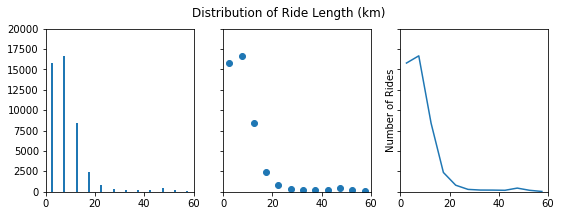

In [0]:
# Example of plotting histogram(s) using matplotlib 

import matplotlib.pyplot as plt

# Use an RDD histogram function to create data for a histogram
start, count_list = rides_sdf.select('distance').rdd.flatMap(lambda x: x).histogram([0,5000,10000,15000, 20000, 25000, 30000,35000, 40000,45000, 50000,55000, 60000] )

# Round distance to meters and then convert to km
start_km = [int(x)/1000.0 for x in start]

# Use the center of the bucket rather than the start in the histogram
center_km = [x + 2.5 for x in start_km]

#delete last element of list
del center_km[-1]

# Define matplotlib plot for categorical data
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex = True, sharey=True)
axs[0].bar(center_km, count_list)
axs[1].scatter(center_km, count_list)
axs[2].plot(center_km, count_list)
plt.ylabel('Number of Rides')
fig.suptitle('Distribution of Ride Length (km)')
plt.ylim(0,20000)
plt.xlim(0,60)

# Display matplotlib figure in notebook
display(fig)

#### Exploring a pair of variables

#### Categorical-Categorical

Let us explore the distribution of a rider's sex by student status.

In [0]:
# Create a two-way frequency table
sdf = rides_sdf.groupBy("rider_student", "rider_sex").count().orderBy("rider_student", "rider_sex")
sdf.show()

sdf.createOrReplaceTempView("sdf_view")

+-------------+---------+-----+
rider_student|rider_sex|count|
+-------------+---------+-----+
 false| null| 1949|
 false| female|17516|
 false| male|23499|
 true| null| 301|
 true| female| 2575|
 true| male| 2935|
+-------------+---------+-----+

In [0]:
# Create column with student or non-student as category and fill missing values in rider_sex
sdf2 = sdf.withColumn("segment", when(sdf.rider_student == True , "student").otherwise("non-student")  ).fillna("other/unknown")
sdf2.createOrReplaceTempView("sdf2_view")

In [0]:
%sql
SELECT * FROM sdf2_view
ORDER BY rider_sex

rider_student,rider_sex,count,segment
true,female,2575,student
false,female,17516,non-student
true,male,2935,student
false,male,23499,non-student
true,other/unknown,301,student
false,other/unknown,1949,non-student


In [0]:
# Get same chart using Databricks
# display(sdf2.sort("rider_sex"))

#### Categorical-Continuous

Let us explore the distribution of ride distance by rider student status.

In [0]:
# We can produce tabular reports in Spark:
rides_sdf\
  .groupBy("rider_student")\
  .agg(count("distance").alias("No. of Rides"), round(mean("distance"),2).alias("Average Distance"), round(stddev("distance"),2).alias("Std. Dev. of Distance"))\
  .orderBy("rider_student")\
  .show()

+-------------+------------+----------------+---------------------+
rider_student|No. of Rides|Average Distance|Std. Dev. of Distance|
+-------------+------------+----------------+---------------------+
 false| 40163| 9350.69| 9185.91|
 true| 5678| 5747.72| 4069.77|
+-------------+------------+----------------+---------------------+

In [0]:
# Alternatively, we can produce visualizations on a sample
sample_sdf = rides_sdf \
  .select("rider_student", "distance","duration") \
  .sample(False, 0.01, 12345) \
  .withColumn("segment", when(rides_sdf.rider_student == True , "student").otherwise("non-student")  )
sample_sdf.createOrReplaceTempView("sample_sdf_view")

In [0]:
%sql
SELECT * FROM sample_sdf_view

rider_student,distance,duration,segment
false,16043,1299,non-student
false,11717,759,non-student
false,1598,255,non-student
false,2100,237,non-student
false,15823,818,non-student
false,6007,580,non-student
false,8921,672,non-student
false,16142,888,non-student
false,5901,670,non-student
false,8681,636,non-student


In [0]:
%sql
SELECT * FROM sample_sdf_view

rider_student,distance,duration,segment
false,16043,1299,non-student
false,11717,759,non-student
false,1598,255,non-student
false,2100,237,non-student
false,15823,818,non-student
false,6007,580,non-student
false,8921,672,non-student
false,16142,888,non-student
false,5901,670,non-student
false,8681,636,non-student


#### Continuous-Continuous

In [0]:
# Use the `corr`, `covar_samp`, and `covar_pop` aggregate functions to measure
# the linear relationship between two variables
rides_sdf.agg(corr("distance", "duration"),
              covar_samp("distance", "duration"),
              covar_pop("distance", "duration")).show()

+------------------------+------------------------------+-----------------------------+
corr(distance, duration)|covar_samp(distance, duration)|covar_pop(distance, duration)|
+------------------------+------------------------------+-----------------------------+
 0.9310626198154082| 2960621.9852197496| 2960557.4006342213|
+------------------------+------------------------------+-----------------------------+

In [0]:
display(sample_sdf)


rider_student,distance,duration,segment
false,16043,1299,non-student
false,11717,759,non-student
false,1598,255,non-student
false,2100,237,non-student
false,15823,818,non-student
false,6007,580,non-student
false,8921,672,non-student
false,16142,888,non-student
false,5901,670,non-student
false,8681,636,non-student


#### Exploring more than two variables

There are numerous ways to explore more than two variables.  The appropriate table or plot depends on the variable types and particular question you are trying to answer.  We highlight a few common approaches below.

#### N-way summary tables

We can use grouping and aggregate functions in Spark to produce summaries.

In [0]:

# Example: Three categorical variables
rides_sdf \
  .groupby("service", "rider_student", "rider_sex") \
  .count() \
  .orderBy("service", "rider_student")\
  .show()


+-------+-------------+---------+-----+
service|rider_student|rider_sex|count|
+-------+-------------+---------+-----+
 Car| false| null| 1487|
 Car| false| female|12902|
 Car| false| male|14648|
 Car| true| male| 1004|
 Car| true| female| 1209|
 Car| true| null| 136|
 Elite| false| female| 336|
 Elite| false| male| 991|
 Elite| false| null| 22|
 Elite| true| female| 261|
 Elite| true| null| 17|
 Elite| true| male| 482|
 Grand| false| female| 2068|
 Grand| false| null| 197|
 Grand| false| male| 2402|
 Grand| true| female| 646|
 Grand| true| null| 130|
 Grand| true| male| 754|
 Noir| false| male| 5458|
 Noir| false| female| 2210|
+-------+-------------+---------+-----+
only showing top 20 rows

In [0]:
# Example: Two categorical variables and one continuous variable
rides_sdf \
  .cube("rider_student", "rider_sex") \
  .agg(grouping_id(), mean("distance"), stddev("distance")) \
  .orderBy("rider_student", "rider_sex") \
  .show()

+-------------+---------+-------------+-----------------+---------------------+
rider_student|rider_sex|grouping_id()| avg(distance)|stddev_samp(distance)|
+-------------+---------+-------------+-----------------+---------------------+
 null| null| 2|9336.221077283373| 7656.3658693304|
 null| null| 3|8904.418948103226| 8797.103315891005|
 null| female| 2|8795.819441539426| 8710.739869810906|
 null| male| 2| 8951.40289642828| 8953.964885557005|
 false| null| 0|9889.842506811989| 7980.955746516462|
 false| null| 1|9350.693772875533| 9185.907991574215|
 false| female| 0|9263.795481927711| 9131.345477347784|
 false| male| 0|9371.550441826215| 9320.275331339617|
 true| null| 0|5949.903333333334| 3781.0263945092306|
 true| null| 1|5747.720147939415| 4069.7699549733625|
 true| female| 0|5718.005546751188| 3951.826205373927|
 true| male| 0|5752.746320953049| 4200.448778217446|
+-------------+---------+-------------+-----------------+---------------------+

###Hands On

![Hands-on](https://cis442f-open-data.s3.amazonaws.com/pictures/hands.png "Hands-on")


#### Exercises

(1) Explore the distribution of ride rating.

(2) Explore the distribution of ride duration.

(3) Explore the relationship between ride rating and rider student status.